# Compare Credibile Sets

**Created**: 4 February 2022

## Environment

In [1]:
if (!requireNamespace("Rcpp", quietly=T)) {
    install.packages("Rcpp")
}

if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(data.table)
library(Rcpp)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("01_Colocalization/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [3]:
cis.eqtl <- readRDS("/nfs/users/nfs_n/nm18/gains_team282/eqtl/cisresults/ciseqtl_all.rds")

In [4]:
head(cis.eqtl)

snps,gene,statistic,pvalue,beta,se,chr,SNPpos,TSS,threshold
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>
rs114383479,ENSG00000000457,-0.06041776,0.9518546,-0.001449258,0.02398729,1,168894411,169894267,3.879445e-05
rs4656623,ENSG00000000457,-0.27193507,0.7856788,-0.003581294,0.01316967,1,168894562,169894267,3.879445e-05
rs74123028,ENSG00000000457,-0.33215439,0.7398440,-0.010030780,0.03019915,1,168894650,169894267,3.879445e-05
rs74123029,ENSG00000000457,-0.33215439,0.7398440,-0.010030780,0.03019915,1,168894789,169894267,3.879445e-05
rs74123030,ENSG00000000457,-0.33215439,0.7398440,-0.010030780,0.03019915,1,168894934,169894267,3.879445e-05
rs74123031,ENSG00000000457,-0.33215439,0.7398440,-0.010030780,0.03019915,1,168894958,169894267,3.879445e-05


In [5]:
cis.eqtl.conditional <- readRDS("/nfs/users/nfs_n/nm18/gains_team282/eqtl/cisresults/conditionalanalysis/conditional_eQTL_results_final.rds")

In [6]:
head(cis.eqtl.conditional)

,SNP,Gene,eQTL_beta,eQTL_SE,pvalue,Number
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,rs10753794,ENSG00000000457,0.0498587312408011,0.00708515851579373,5.19259471106013e-12,1
2,rs10919255,ENSG00000000460,-0.0726264894633498,0.0136853304567293,1.72815915933528e-07,1
3,rs77006036,ENSG00000000460,0.166236949102582,0.0334472538699365,8.47290238610159e-07,2
4,rs12406047,ENSG00000000971,0.17135374034767,0.0379807691167313,7.51523462853891e-06,1
5,rs6696136,ENSG00000001460,0.45884434698694,0.0871081626842823,1.94887370606405e-07,1
6,rs6676449,ENSG00000001460,-0.371531778822554,0.0880672792106829,2.8471651589813e-05,2


In [7]:
ld.tags <- fread("~/gains_team282/nikhil/colocalization/cis_eqtl/fine_mapping/LD/conditional_snps.80r2.tags.tsv") %>%
    dplyr::mutate(NTAG = NTAG + 1) %>%
    dplyr::mutate(SNP = gsub(":", "\\.", SNP)) %>%
    merge(cis.eqtl.conditional, by="SNP")

In [8]:
susie.snps <- lapply(1:22, function(chr) {
    read.table(paste0("~/gains_team282/nikhil/colocalization/cis_eqtl/fine_mapping/SuSiE/conditional/conditional_chr", chr, "_credible_sets.tsv"), sep="\t", header=T)
}) %>% do.call(rbind, .) %>%
    as.data.frame() %>%
    dplyr::filter(is.na(Notes)) %>%
    dplyr::select(-Notes) %>%
    dplyr::mutate(Signal=as.numeric(gsub("^.*-", "", Gene))) %>%
    dplyr::mutate(Gene=gsub("-.*$", "", Gene)) %>%
    dplyr::select(Gene, Signal, SNP, SNP_Prob, Credible_Set)

In [9]:
head(susie.snps)

,Gene,Signal,SNP,SNP_Prob,Credible_Set
,<chr>,<dbl>,<chr>,<dbl>,<int>
1,ENSG00000177868,1,rs2816599,0.23737399,1
2,ENSG00000177868,1,rs2816600,0.23737399,1
3,ENSG00000177868,1,rs323719,0.23737399,1
4,ENSG00000177868,1,rs655741,0.23737399,1
5,ENSG00000177868,1,rs2760082,0.05046393,1
6,ENSG00000179862,2,rs75945124,0.96558163,1


In [10]:
finemap.snps <- lapply(1:22, function(chr) {
    fread(paste0("/nfs/users/nfs_n/nm18/gains_team282/nikhil/colocalization/cis_eqtl/fine_mapping/FINEMAP/conditional/conditional_chr", chr, "_credible_sets.tsv"), sep="\t", header=TRUE) %>%
        as.data.frame() %>%
        dplyr::group_by(Gene)
}) %>% do.call(rbind, .) %>%
    as.data.frame()

In [11]:
head(finemap.snps)

,Gene,Signal,Credibility_Set_Min_LD,Credibility_Set_Mean_LD,Credibility_Set_Median_LD,SNP,Prob_SNP_in_CS
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,ENSG00000000457,1,0.949691,0.990364,0.995332,rs10919236,0.1092880
2,ENSG00000000457,1,0.949691,0.990364,0.995332,rs10753794,0.1092880
3,ENSG00000000457,1,0.949691,0.990364,0.995332,rs10919237,0.0815248
4,ENSG00000000457,1,0.949691,0.990364,0.995332,rs6683782,0.0815248
5,ENSG00000000457,1,0.949691,0.990364,0.995332,rs6701718,0.0815248
6,ENSG00000000457,1,0.949691,0.990364,0.995332,rs12404614,0.0815248


## Compare Credible Sets

Each eGene-Signal pair has exactly one credibility set from both FINEMAP and SuSiE. The lead eSNP also has a set of tagging SNPs at $R^2 > 0.8$.

There were a total of 16,054 eGene-signal pairs. Of those, only 11,055 had a credible set from SuSiE. If using the same pruning filter for FINEMAP, 10,332 eGene-signal pairs have a credible set.

In [12]:
dim(cis.eqtl.conditional)

[1] 16054     6

In [13]:
susie.snps %>%
    dplyr::select(Gene, Signal) %>%
    unique() %>% nrow()

[1] 11055

In [14]:
finemap.snps %>%
    dplyr::filter(Credibility_Set_Min_LD >= 0.5) %>%
    dplyr::select(Gene, Signal) %>%
    unique() %>% nrow()

[1] 10332

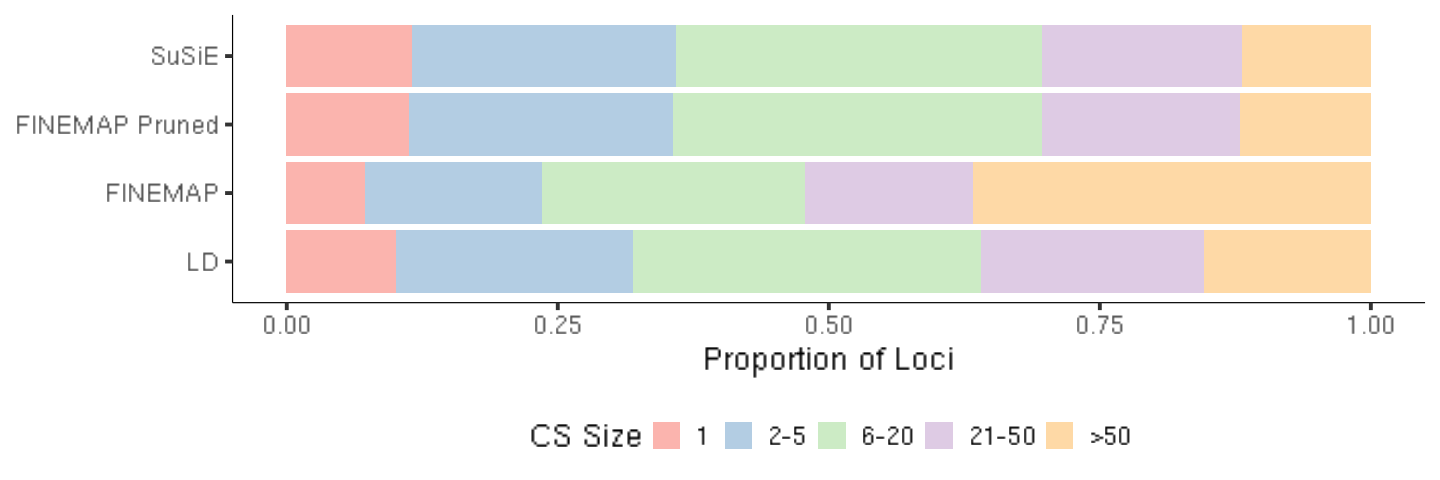

In [18]:
options(repr.plot.width=12, repr.plot.height=4)

dplyr::bind_rows(
    ld.tags %>%
        dplyr::mutate(Method="LD") %>%
        dplyr::select(Method, Gene, Signal=Number, N.SNPs=NTAG),
    susie.snps %>%
        dplyr::group_by(Gene, Signal) %>%
        dplyr::summarize(N.SNPs=n(), .groups="drop") %>%
        dplyr::mutate(Method="SuSiE") %>%
        dplyr::select(Method, Gene, Signal, N.SNPs),
    finemap.snps %>%
        dplyr::filter(Credibility_Set_Min_LD >= 0.5) %>%
        dplyr::group_by(Gene, Signal) %>%
        dplyr::summarize(N.SNPs=n(), .groups="drop") %>%
        dplyr::mutate(Method="FINEMAP Pruned") %>%
        dplyr::select(Method, Gene, Signal, N.SNPs),
    finemap.snps %>%
        dplyr::group_by(Gene, Signal) %>%
        dplyr::summarize(N.SNPs=n(), .groups="drop") %>%
        dplyr::mutate(Method="FINEMAP") %>%
        dplyr::select(Method, Gene, Signal, N.SNPs)
) %>%
    dplyr::mutate(CS.Size=cut(N.SNPs, breaks=c(0, 1, 5, 20, 50, Inf), labels=c("1", "2-5", "6-20", "21-50", ">50"), include.lowest=F)) %>%
    dplyr::mutate(Method=factor(Method, levels=c("LD", "FINEMAP", "FINEMAP Pruned", "SuSiE"))) %>%
    dplyr::group_by(Method, CS.Size) %>%
    dplyr::summarize(N=n(), .groups="drop") %>%
    dplyr::group_by(Method) %>%
    dplyr::mutate(Freq=N / sum(N)) %>%
    ggplot() +
    geom_bar(aes(x=Method, y=Freq, fill=CS.Size), stat="identity", position=position_stack(reverse=T)) +
    scale_fill_brewer("CS Size", palette="Pastel1") +
    ylab("Proportion of Loci") +
    coord_flip() +
    ggplot_theme +
    theme(axis.title.y=element_blank())

ggsave("01_Colocalization/results/cs_sizes.pdf", width=12, height=4)

## Paired Tests of Credible Sets

Combine all credible set sizes based on SuSiE results to perform paired tests.

In [16]:
cs.sizes <- merge(
    susie.snps %>%
        dplyr::group_by(Gene, Signal) %>%
        dplyr::summarize(SuSiE.N.SNPs=n(), .groups="drop"),
    finemap.snps %>%
        dplyr::filter(Credibility_Set_Min_LD >= 0.5) %>%
        dplyr::group_by(Gene, Signal) %>%
        dplyr::summarize(FINEMAP.N.SNPs=n(), .groups="drop"),
    by=c("Gene", "Signal")
) %>%
    merge(., ld.tags, by.x=c("Gene", "Signal"), by.y=c("Gene", "Number")) %>%
    dplyr::select(Gene, Signal, SuSiE.N.SNPs, FINEMAP.N.SNPs, NTAG)

In [17]:
head(cs.sizes)

,Gene,Signal,SuSiE.N.SNPs,FINEMAP.N.SNPs,NTAG
,<chr>,<dbl>,<int>,<int>,<dbl>
1,ENSG00000000457,1,19,19,23
2,ENSG00000000460,1,27,29,22
3,ENSG00000001036,1,66,67,71
4,ENSG00000001167,1,63,63,71
5,ENSG00000001460,1,13,20,39
6,ENSG00000001461,1,27,28,34


In [18]:
dim(cs.sizes)

[1] 10332     5

The median size of the LD snp sets is much higher than FINEMAP and SuSiE when using the SuSiE pruned set. The FINEMAP median is much higher by itself (23) and the LD snp sets are actually smaller (12).

In [19]:
cs.sizes %>%
    tidyr::gather(key="Method", value="N.SNPs", -Gene, -Signal) %>%
    dplyr::group_by(Method) %>%
    dplyr::summarize(Median.CS.Size=median(N.SNPs))

Method,Median.CS.Size
<chr>,<dbl>
FINEMAP.N.SNPs,10
NTAG,14
SuSiE.N.SNPs,9


In [20]:
wilcox.test(cs.sizes$NTAG, cs.sizes$SuSiE.N.SNPs, paired=TRUE)


	Wilcoxon signed rank test with continuity correction

data:  cs.sizes$NTAG and cs.sizes$SuSiE.N.SNPs
V = 28399524, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [21]:
wilcox.test(cs.sizes$NTAG, cs.sizes$FINEMAP.N.SNPs, paired=TRUE)


	Wilcoxon signed rank test with continuity correction

data:  cs.sizes$NTAG and cs.sizes$FINEMAP.N.SNPs
V = 27142804, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [22]:
wilcox.test(cs.sizes$SuSiE.N.SNPs, cs.sizes$FINEMAP.N.SNPs, paired=TRUE)


	Wilcoxon signed rank test with continuity correction

data:  cs.sizes$SuSiE.N.SNPs and cs.sizes$FINEMAP.N.SNPs
V = 318323, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


## CS with Large Sizes

What is causing the CS to explode in size even though only a few SNPs are in LD?
1. Could be a difference in the underlying LD structure, but the LD tagging SNP set size distribution is similar
2. Could be a difference in the effect size of the eQTL? Do these eQTL have smaller betas? Do they have larger p-values for the lead SNP?

In [23]:
pruned.out.cs <- finemap.snps %>%
    dplyr::filter(Credibility_Set_Min_LD < 0.5) %>%
    dplyr::group_by(Gene, Signal) %>%
    dplyr::summarize(FINEMAP.N.SNPs=n(), .groups="drop") %>%
    merge(., ld.tags, by.x=c("Gene", "Signal"), by.y=c("Gene", "Number"))

In [24]:
dim(pruned.out.cs)

[1] 5722   14

In [25]:
pruned.out.cs %>%
    dplyr::select(Gene, Signal, NTAG, FINEMAP.N.SNPs) %>%
    tidyr::gather("Method", "SNPs", -Gene, -Signal) %>%
    dplyr::group_by(Method) %>%
    dplyr::summarize(Median.SNPs=median(SNPs))

Method,Median.SNPs
<chr>,<dbl>
FINEMAP.N.SNPs,474.5
NTAG,8.0


In [26]:
wilcox.test(pruned.out.cs$NTAG, pruned.out.cs$FINEMAP.N.SNPs, paired=TRUE)


	Wilcoxon signed rank test with continuity correction

data:  pruned.out.cs$NTAG and pruned.out.cs$FINEMAP.N.SNPs
V = 192090, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


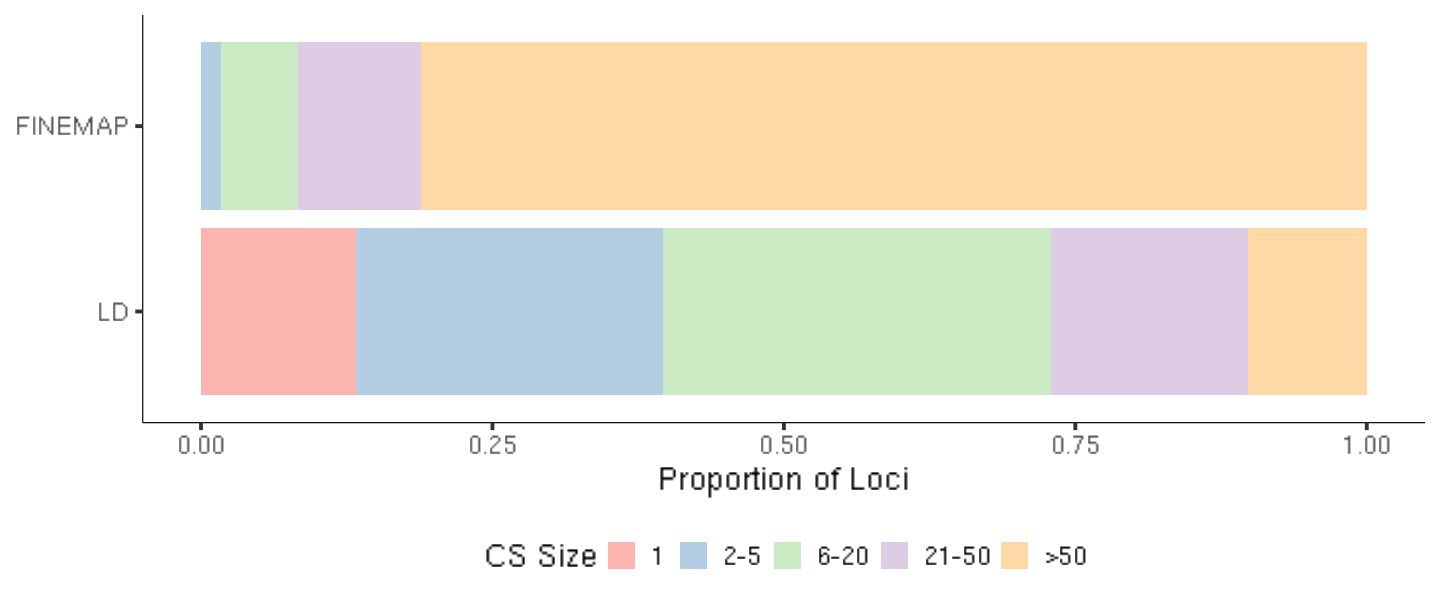

In [27]:
pruned.out.cs %>%
    dplyr::select(Gene, Signal, LD=NTAG, FINEMAP=FINEMAP.N.SNPs) %>%
    tidyr::gather("Method", "SNPs", -Gene, -Signal) %>%
    dplyr::mutate(CS.Size=cut(SNPs, breaks=c(0, 1, 5, 20, 50, Inf), labels=c("1", "2-5", "6-20", "21-50", ">50"), include.lowest=F)) %>%
    dplyr::mutate(Method=factor(Method, levels=c("LD", "FINEMAP"))) %>%
    dplyr::group_by(Method, CS.Size) %>%
    dplyr::summarize(N=n(), .groups="drop") %>%
    dplyr::group_by(Method) %>%
    dplyr::mutate(Freq=N / sum(N)) %>%
    ggplot() +
    geom_bar(aes(x=Method, y=Freq, fill=CS.Size), stat="identity", position=position_stack(reverse=T)) +
    scale_fill_brewer("CS Size", palette="Pastel1") +
    ylab("Proportion of Loci") +
    coord_flip() +
    ggplot_theme +
    theme(axis.title.y=element_blank())

In [28]:
pruned.out.z <- finemap.snps %>%
    dplyr::mutate(Pruned=Credibility_Set_Min_LD < 0.5) %>%
    dplyr::group_by(Gene, Signal) %>%
    dplyr::summarize(FINEMAP.N.SNPs=n(), Pruned=Pruned[1], .groups="drop") %>%
    merge(., ld.tags, by.x=c("Gene", "Signal"), by.y=c("Gene", "Number")) %>%
    dplyr::mutate(eQTL_beta=as.numeric(eQTL_beta), eQTL_SE=as.numeric(eQTL_SE), pvalue=as.numeric(pvalue)) %>%
    dplyr::mutate(abs.Z=abs(eQTL_beta / eQTL_SE))

In [29]:
pruned.out.z %>%
    dplyr::group_by(Pruned) %>%
    dplyr::summarize(Median.Z=median(abs.Z))

Pruned,Median.Z
<lgl>,<dbl>
FALSE,7.803737
TRUE,4.627334


In [30]:
wilcox.test(pruned.out.z$abs.Z[pruned.out.z$Pruned], pruned.out.z$abs.Z[!pruned.out.z$Pruned])


	Wilcoxon rank sum test with continuity correction

data:  pruned.out.z$abs.Z[pruned.out.z$Pruned] and pruned.out.z$abs.Z[!pruned.out.z$Pruned]
W = 3909231, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
